In [1]:
import sys
sys.path.insert(0, "..")

import os, glob
import yaml
from pathlib import Path

import torch
from torch.utils.data import DataLoader

#from cutmix.cutmix import CutMix
#from cutmix.utils import CutMixCrossEntropyLoss

from utils.models import get_model
from utils.data import CustomImageDataset
from utils.log import TextDocument

In [2]:
NUM_CLASSES = 4 
RESUME = False
epochs = 10
IMG_SIZE = 640
BATCH_SIZE = 4
ACCUM_STEPS = 16
WEIGHTS_DIR = "../weights"
CUTMIX = False
model_names = ["resnet50", "cspresnet50", "efficientnet_b1", "dpn68"]

TRAIN_DATASET = "../../../Dataset/Covid19/train_test_classification_quarter_size/train"
VALID_DATASET = "../../../Dataset/Covid19/train_test_classification_quarter_size/valid"

TRAIN_DATASET += "/*/*.jpg"
VALID_DATASET += "/*/*.jpg"
Path(WEIGHTS_DIR).mkdir(exist_ok=True, parents=True)

In [3]:
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import cv2
import numpy as np

from torchvision.transforms import Compose, Resize, Normalize, ToTensor, Lambda
from torchvision.transforms import ColorJitter, RandomAffine, RandomPerspective, RandomRotation, RandomErasing, RandomCrop, Grayscale
from torchvision.transforms import RandomChoice, RandomApply

def get_train_grayscale_transforms(img_size: int) -> Compose:
    """Returns data transformations/augmentations for train dataset.
    
    Args:
        img_size: The resolution of the input image (img_size x img_size)
    """
    return Compose([
        RandomApply([
            ColorJitter(brightness=0.3, contrast=0.01, saturation=0.01, hue=0),
            RandomAffine(0.1, translate=(0.04,0.04), scale=(0.04,0.04), shear=0.01, resample=2),
            RandomCrop(30),
            RandomPerspective(0.1)
        ]),
        Resize([img_size, img_size], interpolation=3),
        ToTensor(),
        Normalize(
            mean=[0.5203580774185134],
            std=[0.24102417452995067])
    ])
def get_test_grayscale_transforms(img_size: int) -> Compose:
    """Returns data transformations/augmentations for train dataset.
    
    Args:
        img_size: The resolution of the input image (img_size x img_size)
    """
    return Compose([
        Resize([img_size, img_size], interpolation=3),
        ToTensor(),
        Normalize(
            mean=[0.5203580774185134],
            std=[0.24102417452995067])
    ])

def show_confusion_matrix(matrix: List[List], labels: List[str]):
    """Display a nice confusion matrix given
    the confusion matrix in a 2D list + list of labels (decoder)
    
    Args:
        matrix: 2D array containing the values to display (confusion matrix)
        labels: Array containing the labels (indexed by corresponding label idx)
    """
    fig, ax = plt.subplots()
    fig.set_figheight(15)
    fig.set_figwidth(15)

    min_val, max_val = 0, len(labels)

    for i in range(max_val):
        for j in range(max_val):
            c = matrix[i][j]
            ax.text(i, j, str(int(c)), va='center', ha='center')

    ax.matshow(matrix, cmap=plt.cm.Blues)

    # Set number of ticks for x-axis
    ax.set_xticks(np.arange(max_val))
    # Set ticks labels for x-axis
    ax.set_xticklabels(labels, rotation='vertical', fontsize=16)

    # Set number of ticks for x-axis
    ax.set_yticks(np.arange(max_val))
    # Set ticks labels for x-axis
    ax.set_yticklabels(labels, rotation='horizontal', fontsize=16)
                    
    #ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val - 0.5, min_val - 0.5)
    plt.show()
    
def display_missclassified(class_to_idx: Dict[str,int], 
                           targets: List[int], 
                           predictions: List[int], 
                           images: List[np.ndarray], 
                           gridsize: Tuple[int] = (4,4)):
    """Display a grid with missclassified samples from test set.
    
    Args:
        class_to_idx: Class to idx encoder
        targets:      List containing all ground truths
        predictions:  List containing all predictions
        images:       List containing image arrays
        gridsize:     Tuple describing the final image grid
    """
    fig = plt.figure()
    plot_counter = 1
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    idx_to_class = {i:label for i, label in enumerate(class_to_idx)}
    for i in range(len(targets)):
        if plot_counter > gridsize[0]*gridsize[1]:
            break
        
        image = images[i].transpose(1, 2, 0)
        image = ((image * std) + mean) * 255
        image = image.astype("uint8")
    
        image = cv2.resize(image, (128, 128))
        image = cv2.putText(image, idx_to_class[predictions[i]], (0,20), 3, 0.4, (0,0,255), 1)
        if predictions[i] == targets[i]:
            pass
        else:
            ax = fig.add_subplot(gridsize[0], gridsize[1], plot_counter)
            ax.imshow(image)
            plot_counter += 1
    plt.show()

In [22]:
def train_one_epoch(model, train_dataloader, device, accumulate_steps=1):
    model.train()
    results = {
        "running_loss": 0
    }
    t = tqdm(train_dataloader)
    for i, (X, y) in enumerate(t):
        

        X = X.to(device)
        y = y.to(device)

        preds = model(X)
        loss = criterion(preds, y)
        
        results["running_loss"] += loss.cpu().detach()
        loss = loss/accumulate_steps
        loss.backward()
        
        if ((i+1) % accumulate_steps) == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        t.set_description(f"{epoch+1}/{epochs} Train: {round(float(results['running_loss'])/(i+1), 4)}")
    optimizer.step()
    optimizer.zero_grad()
    
    return results

def evaluate_model(model, valid_dataloader, device, save_images=False):
    results = {
        "running_loss": 0,
        "targets": list(),
        "predictions": list()
    }    

    model.eval()
    with torch.no_grad():

        if save_images:
            results["images"] = list() 
            
        t = tqdm(valid_dataloader)
        for i, (X, y) in enumerate(t):
            X = X.to(device)
            y = y.to(device)

            preds = model(X)
            results["predictions"] += list(preds.argmax(axis=1).cpu().detach().numpy())
            results["targets"] += list(np.array(y.cpu()))
            if save_images:
                results["images"] += list(np.array(X.cpu()))
        
            loss = criterion(preds, y)

            results["running_loss"] += loss.cpu().detach()
            t.set_description(f"Test: {round(float(results['running_loss']/(i+1)), 4)}")
            
    return results

def calculate_metrics():
    pass

class TrainingResults():
    
    def __init__(self, metrics):
        self.best_results = {metric: [1e99, -1e99] for metric in metrics}
    
    def isHighest(self, metric, value):
        if self.best_results[metric][1] < value:
            self.best_results[metric][1] = value
            return True
        return False
    
    def isLowest(self, metric, value):
        if self.best_results[metric][0] > value:
            self.best_results[metric][0] = value
            return True
        return False
    
    def loadCheckpoint(self, checkpoint):
        self.best_results = checkpoint

In [5]:
train_imgs = glob.glob(TRAIN_DATASET)
valid_imgs = glob.glob(VALID_DATASET)

train_labels = set([os.path.basename(os.path.dirname(img_path)) for img_path in train_imgs])
valid_labels = set([os.path.basename(os.path.dirname(img_path)) for img_path in valid_imgs])
class_to_idx = {label: idx for idx, label in enumerate(train_labels)}

train_dataset = CustomImageDataset(train_imgs, get_test_grayscale_transforms(IMG_SIZE), train_labels)
if CUTMIX:
    train_dataset = CutMix(train_dataset, num_class=NUM_CLASSES, beta=1.0, prob=0.5, num_mix=3)    # this is paper's original setting for cifar.
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)

valid_dataset = CustomImageDataset(valid_imgs, get_test_grayscale_transforms(IMG_SIZE), valid_labels)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True)
print(class_to_idx)

{'indeterminate': 0, 'typical': 1, 'atypical': 2, 'negative': 3}


C:\Users\SEFuDA\.conda\envs\siimcovid19\lib\site-packages\torchvision\transforms\transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [6]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

# Using gpu or not
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print(f"Using CPU")
    
for model_name in model_names:
    model = get_model(model_name, NUM_CLASSES, 1)
    model.to(device)
    print(list(class_to_idx.keys()))

    results_document = TextDocument(f"{model_name}_results.txt")
    results_document.add_line(f"acc f1 recall precision valid_loss train_loss") 
    metrics = ["acc", "f1", "valid_loss"]
    training_results = TrainingResults(metrics)
    
    if RESUME:
        pass
        #start_epoch = state_dict["epoch"]
        #optimizer_state_dict = state_dict["optimizer_state_dict"]
        
        #model.load_state_dict(state_dict["model_state_dict"])
        #optimizer.load_state_dict(state_dict["optimizer_state_dict"])
        training_results.loadCheckpoint(state_dict["training_results"])
    else:
        
        optimizer = torch.optim.Adam(model.parameters())
        if CUTMIX:
            criterion = CutMixCrossEntropyLoss(True)
        else:
            criterion = torch.nn.CrossEntropyLoss()
        start_epoch = 0

    for epoch in range(start_epoch, epochs):
        
        # Train one epoch    
        results = train_one_epoch(model, train_dataloader, device, accumulate_steps=ACCUM_STEPS)
        train_loss = float(results["running_loss"])


        if epoch+1 == epochs:
            results = evaluate_model(model, valid_dataloader, device, save_images=True)
            images = results["images"]
        else:
            results = evaluate_model(model, valid_dataloader, device, save_images=False)

        valid_loss = float(results["running_loss"])
        acc = accuracy_score(results["targets"], results["predictions"])
        f1 = f1_score(results["targets"], results["predictions"], average="macro", labels=np.unique(results["predictions"]))
        recall = recall_score(results["targets"], results["predictions"], average="macro", labels=np.unique(results["predictions"]))
        precision = precision_score(results["targets"], results["predictions"], average="macro", labels=np.unique(results["predictions"]))
        results_document.add_line(f"{float(acc)} {float(f1)} {float(recall)} {float(precision)} {valid_loss} {train_loss}")
    
        if training_results.isHighest('f1',  f1):
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'training_results': training_results.best_results,
                'train_dataloader': train_dataloader,
                'test_dataloader': valid_dataloader,
                'class_to_idx': class_to_idx
            }, os.path.join(WEIGHTS_DIR, f"{model_name}_best_f1.pt"))
        if training_results.isHighest('acc', acc):
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'training_results': training_results.best_results,
                'train_dataloader': train_dataloader,
                'test_dataloader': valid_dataloader,
                'class_to_idx': class_to_idx
            }, os.path.join(WEIGHTS_DIR, f"{model_name}_best_acc.pt"))
        if training_results.isLowest('valid_loss', valid_loss):
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'training_results': training_results.best_results,
                'train_dataloader': train_dataloader,
                'test_dataloader': valid_dataloader,
                'class_to_idx': class_to_idx
            }, os.path.join(WEIGHTS_DIR, f"{model_name}_best_valid_loss.pt"))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_results': training_results.best_results,
            'train_dataloader': train_dataloader,
            'test_dataloader': valid_dataloader,
            'class_to_idx': class_to_idx
        }, os.path.join(WEIGHTS_DIR, f"{model_name}_last.pt"))

    #display_missclassified(class_to_idx, targets, predictions, images, gridsize=(4,4))
    #show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))

Using GPU: NVIDIA GeForce RTX 3070 Laptop GPU


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/cspresnet50_ra-d3e8d487.pth" to C:\Users\SEFuDA/.cache\torch\hub\checkpoints\cspresnet50_ra-d3e8d487.pth
  0%|                                                                                         | 0/1334 [00:00<?, ?it/s]

['indeterminate', 'typical', 'atypical', 'negative']


C:\Users\SEFuDA\.conda\envs\siimcovid19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Test: 1.211: 100%|███████████████████████████████████████████████████████████████████| 250/250 [00:44<00:00,  5.62it/s]
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to C:\Users\SEFuDA/.cache\torch\hub\checkpoints\efficientnet_b1-533bc792.pth
  0%|                                                                                         | 0/1334 [00:00<?, ?it/s]

['indeterminate', 'typical', 'atypical', 'negative']


Test: 1.6245: 100%|██████████████████████████████████████████████████████████████████| 250/250 [00:41<00:00,  5.97it/s]
Downloading: "https://github.com/rwightman/pytorch-dpn-pretrained/releases/download/v0.1/dpn68-66bebafa7.pth" to C:\Users\SEFuDA/.cache\torch\hub\checkpoints\dpn68-66bebafa7.pth
  0%|                                                                                         | 0/1334 [00:00<?, ?it/s]

['indeterminate', 'typical', 'atypical', 'negative']


  0%|                                                                                         | 0/1334 [00:00<?, ?it/s]

['indeterminate', 'typical', 'atypical', 'negative']


Test: 1.0523: 100%|██████████████████████████████████████████████████████████████████| 250/250 [00:44<00:00,  5.58it/s]


In [7]:
display_missclassified(class_to_idx, targets, predictions, images, gridsize=(4,4))
show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))


NameError: name 'targets' is not defined

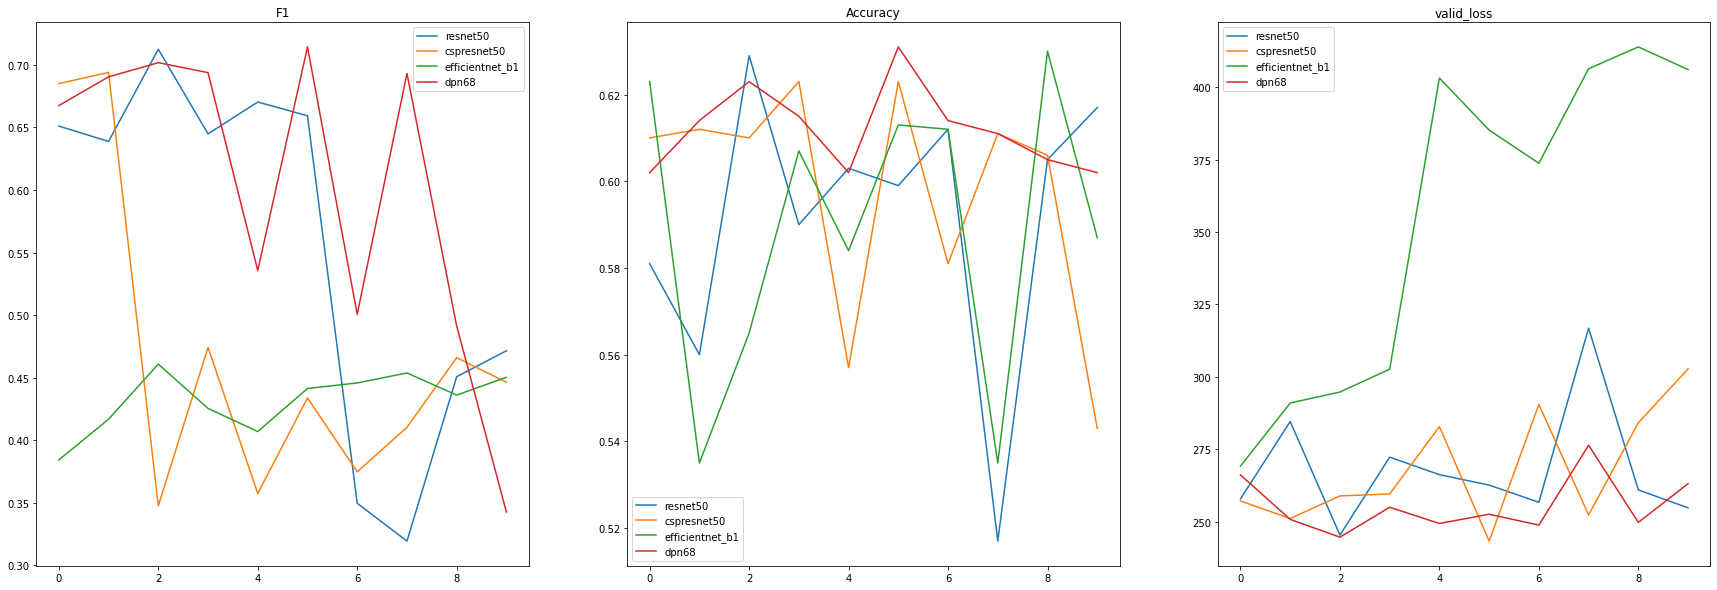

In [14]:
def read_results(txt_path):
    with open(txt_path) as f:
        data = f.readlines()
    columns = data[0].replace('\n', '').split()
    rows = [line.replace('\n', '').split() for line in data[1:]]
    for idx, row in enumerate(rows):
        rows[idx] = [float(i) for i in row]
    results_dict = {column: [row[i] for row in rows] for i, column in enumerate(columns)}
    return results_dict

model_names = ["resnet50", "cspresnet50", "efficientnet_b1", "dpn68"]
fig, axs = plt.subplots(1,3, figsize=(30,10))
for model_name in model_names:
    txt_path = model_name + "_results.txt"
    data = read_results(txt_path)

    axs[0].plot(data['f1'])
    axs[1].plot(data['acc'])
    axs[2].plot(data['valid_loss'])
axs[0].set_title("F1")
axs[1].set_title("Accuracy")
axs[2].set_title("valid_loss")
axs[0].legend(model_names)
axs[1].legend(model_names)
axs[2].legend(model_names)

In [16]:
print(data.keys())

dict_keys(['acc', 'f1', 'recall', 'precision', 'valid_loss', 'train_loss'])
